In [5]:
pip install seaborn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


Columnas: Index(['Texto', 'Emocion'], dtype='object')


Device set to use cuda:0


Accuracy: 0.715
              precision    recall  f1-score   support

       anger       0.70      0.59      0.64       108
        fear       0.70      0.66      0.68        91
         joy       0.64      0.91      0.75       266
        love       0.88      0.56      0.68        68
     sadness       0.86      0.65      0.74       245
    surprise       0.53      0.41      0.46        22

    accuracy                           0.71       800
   macro avg       0.72      0.63      0.66       800
weighted avg       0.74      0.71      0.71       800



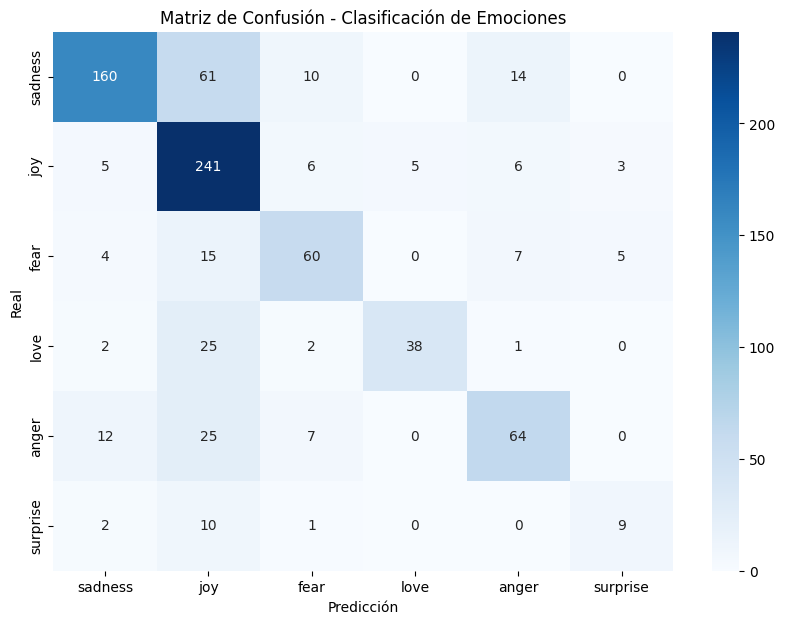

In [7]:
import pandas as pd
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

ruta = Path("/home/misael-villa/Documentos/emotions-wheel-nlp/Datasets/dataset_finaltest_flat.csv")
df = pd.read_csv(ruta)

print("Columnas:", df.columns)

columna_texto = "Texto"
columna_etiqueta = "Emocion"

X = df[columna_texto].astype(str)
y = df[columna_etiqueta].astype(str).str.lower().str.strip()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 2. Cargar modelo fine-tuned para emociones ===
model_name = "mrm8488/t5-base-finetuned-emotion"  # entrenado para clasificación emocional
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0)

# === 3. Generar predicciones ===
etiquetas_validas = set(y.unique())

def limpiar_etiqueta(texto):
    texto = texto.lower().strip()
    return texto if texto in etiquetas_validas else "unknown"

y_pred = []
for texto in X_test:
    entrada = f"classify emotion: {texto}"
    salida = generator(entrada, max_new_tokens=10, clean_up_tokenization_spaces=True)
    etiqueta = limpiar_etiqueta(salida[0]["generated_text"])
    y_pred.append(etiqueta)

# === 4. Evaluar ===
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# === 5. Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred, labels=list(etiquetas_validas))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(etiquetas_validas), yticklabels=list(etiquetas_validas))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Clasificación de Emociones")
plt.show()
